In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import numpy as np

data = pd.read_csv("cleaned_data_15_4_2024.csv")

#features and target variables
feature_columns = ['age', 'Violence and Abuse', 'Accidents and Medical', 'Theft and Fraud',
                   'Loss and Death', 'gender_Female', 'gender_Male', 'gender_Other']
targets = ['Personal Support', 'Professional and Specialized Support','Community and Workplace Support', 'Legal and Official Support', 'No Help Sought']

#Split data based on the survey year
train_data = data[data['year_of_survey'] <= 2021]
validation_data = data[data['year_of_survey'] == 2022]
test_data = data[data['year_of_survey'] == 2023]

#Extract features and targets for each dataset
X_train, y_train = train_data[feature_columns], train_data[targets]
X_val, y_val = validation_data[feature_columns], validation_data[targets]
X_test, y_test = test_data[feature_columns], test_data[targets]

#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Hyperparameters to tune
param_grid = {
    'svc__C': [ 0.1, 1, 10],
    'svc__kernel': ['linear'],
    'svc__gamma': ['scale', 'auto']
}

#Scoring for GridSearchCV
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(recall_score, average='macro')}

#Create an empty list
classifiers = []

#Apply SMOTEENN and GridSearchCV for each label individually
for i, target in enumerate(targets):
    smote_enn = SMOTEENN(smote=SMOTE(random_state=42), enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train[target])
    
    #Define the SVM model pipeline
    pipeline = Pipeline([
        ('svc', SVC(random_state=42, probability=True))  # Enable probability for ROC AUC
    ])
    
    #hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='AUC')
    grid_search.fit(X_resampled, y_resampled)
    
    #Best model
    best_model = grid_search.best_estimator_
    
    classifiers.append(best_model)

y_train_pred = np.column_stack([model.predict(X_train_scaled) for model in classifiers])
y_val_pred = np.column_stack([model.predict(X_val_scaled) for model in classifiers])
y_test_pred = np.column_stack([model.predict(X_test_scaled) for model in classifiers])

precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')
roc_auc_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred[:, i]) for i in range(y_train.shape[1])])

#training set
print(f'Train Precision: {precision_train}')
print(f'Train Recall: {recall_train}')
print(f'Train F1-score: {f1_train}')
print(f'Train ROC-AUC score: {roc_auc_train}')
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred, target_names=targets))

precision_val = precision_score(y_val, y_val_pred, average='macro')
recall_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')
roc_auc_val = np.mean([roc_auc_score(y_val.iloc[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])])

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
roc_auc_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred[:, i]) for i in range(y_test.shape[1])])

#validation set
print(f'Validation Precision: {precision_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1-score: {f1_val}')
print(f'Validation ROC-AUC score: {roc_auc_val}')
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=targets))

#test set
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1-score: {f1_test}')
print(f'Test ROC-AUC score: {roc_auc_test}')
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=targets))


Train Precision: 0.4918481831732254
Train Recall: 0.602483793079502
Train F1-score: 0.5254591342076386
Train ROC-AUC score: 0.6524971728746147

Training Classification Report:
                                       precision    recall  f1-score   support

                    Personal Support       0.90      0.90      0.90      7215
Professional and Specialized Support       0.57      0.60      0.58      1825
     Community and Workplace Support       0.47      0.49      0.48      2427
          Legal and Official Support       0.43      0.63      0.51      1323
                      No Help Sought       0.09      0.39      0.15       471

                           micro avg       0.63      0.74      0.68     13261
                           macro avg       0.49      0.60      0.53     13261
                        weighted avg       0.70      0.74      0.71     13261
                         samples avg       0.72      0.78      0.71     13261

Validation Precision: 0.4880007652932192

In [2]:
import pandas as pd

#Define the evaluation metrics for each data split
metrics_data = {
    'Data Split': ['Train', 'Validation', 'Test'],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_train, f1_val, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_val, roc_auc_test]
}

results_df = pd.DataFrame(metrics_data)

#Display the DataFrame
print(results_df)
results_df.to_csv("SVM_evaluation_metrics.csv", index=False)

   Data Split  Precision    Recall  F1 Score   ROC-AUC
0       Train   0.491894  0.602649  0.525562  0.652562
1  Validation   0.488001  0.586171  0.517654  0.643807
2        Test   0.497974  0.613049  0.532162  0.667496


In [3]:
#Display the best hyperparameters for each classifier
for i, model in enumerate(classifiers):
    print(f"Best hyperparameters for '{targets[i]}':")
    print(model.named_steps['svc'].get_params())
    print()

Best hyperparameters for 'Personal Support':
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Best hyperparameters for 'Professional and Specialized Support':
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Best hyperparameters for 'Community and Workplace Support':
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose':

Error Rates for Personal Support:
  Training: 0.17609145080870728
  Validation: 0.17536746071971618
  Test: 0.152218782249742


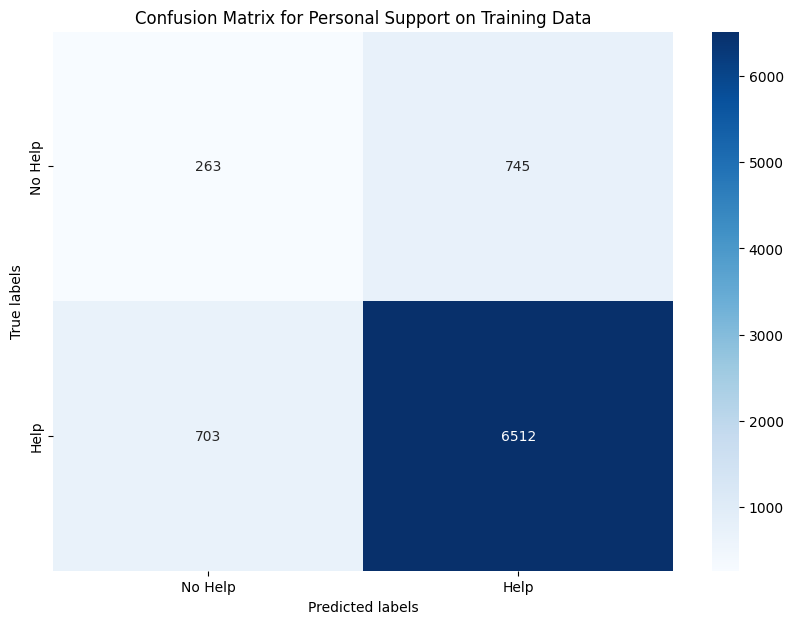

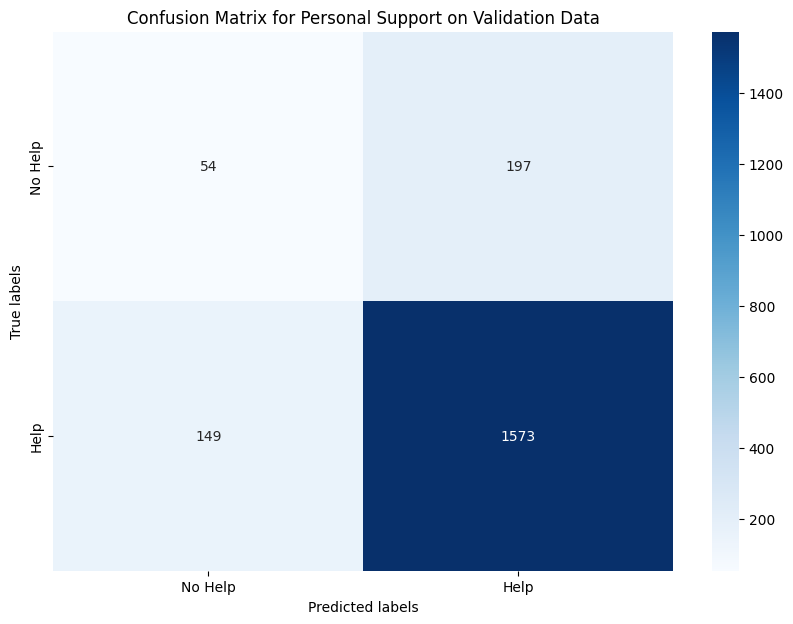

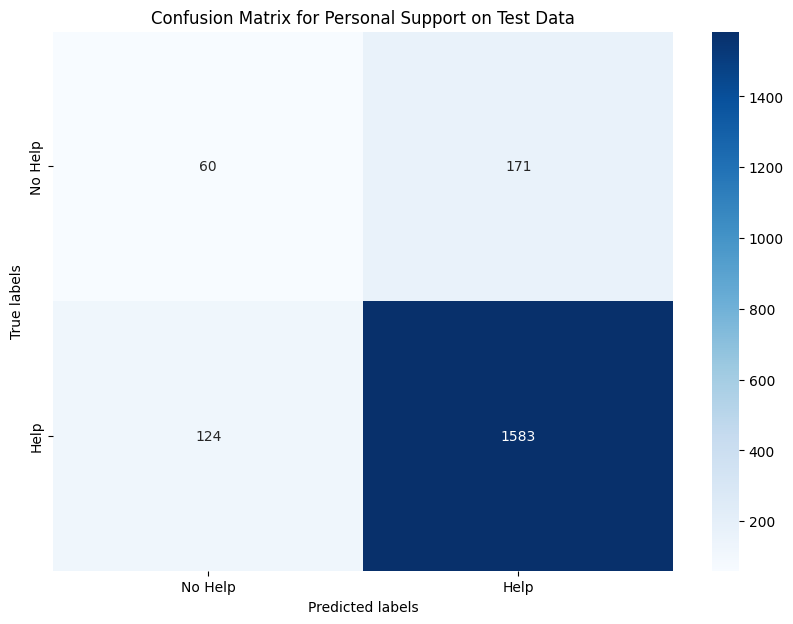

Bias Analysis for Personal Support:
  gender_Female - Train Error Rate: 0.16442110070792418
  gender_Female - Validation Error Rate: 0.14299610894941633
  gender_Female - Test Error Rate: 0.12962962962962962
  gender_Male - Train Error Rate: 0.18973156111545478
  gender_Male - Validation Error Rate: 0.21125265392781317
  gender_Male - Test Error Rate: 0.17802197802197803
  gender_Other - Train Error Rate: 0.0
  gender_Other - Validation Error Rate: 0.0
  gender_Other - Test Error Rate: 0.0
Error Rates for Professional and Specialized Support:
  Training: 0.190684664964125
  Validation: 0.18144956918398378
  Test: 0.1867905056759546


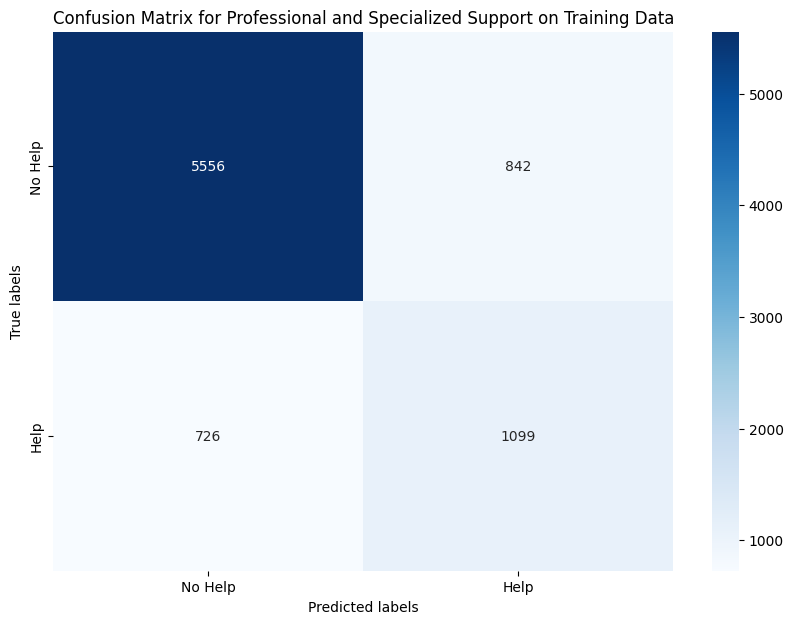

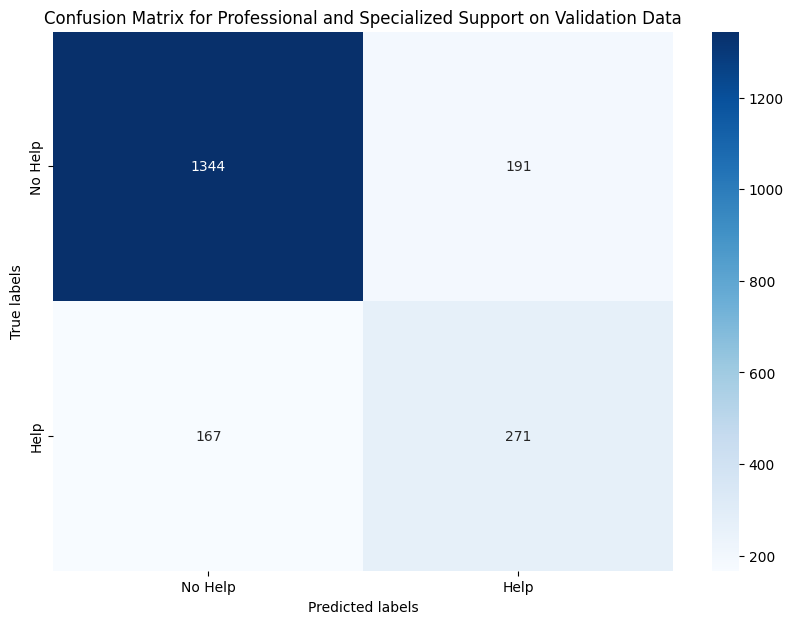

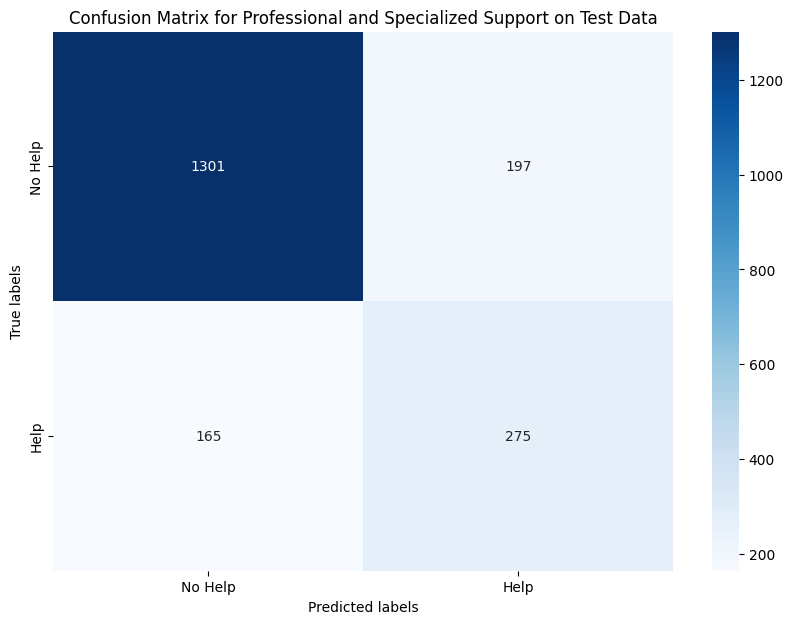

Bias Analysis for Professional and Specialized Support:
  gender_Female - Train Error Rate: 0.19319479333181092
  gender_Female - Validation Error Rate: 0.18385214007782102
  gender_Female - Test Error Rate: 0.1871345029239766
  gender_Male - Train Error Rate: 0.18686473807662235
  gender_Male - Validation Error Rate: 0.17834394904458598
  gender_Male - Test Error Rate: 0.18461538461538463
  gender_Other - Train Error Rate: 0.7142857142857143
  gender_Other - Validation Error Rate: 0.3333333333333333
  gender_Other - Test Error Rate: 1.0
Error Rates for Community and Workplace Support:
  Training: 0.3120515626900158
  Validation: 0.2899138367967562
  Test: 0.29205366357069146


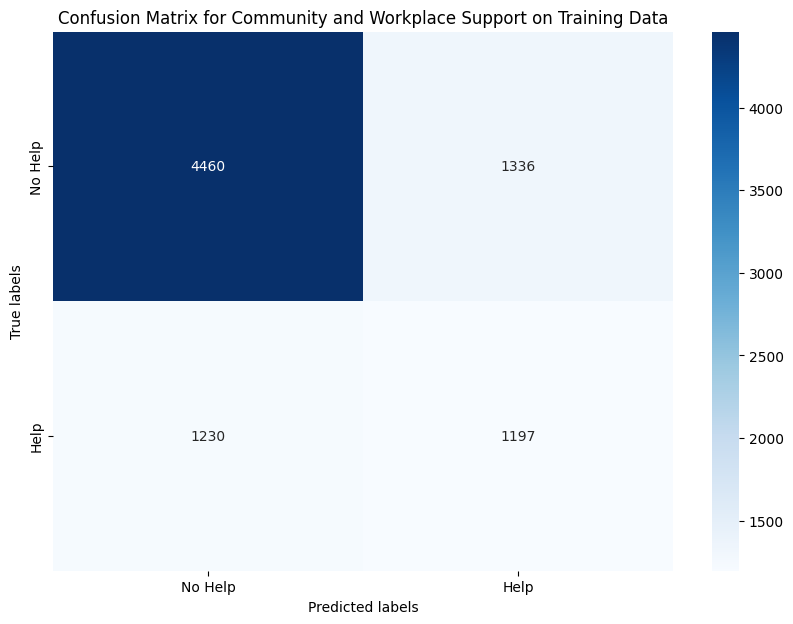

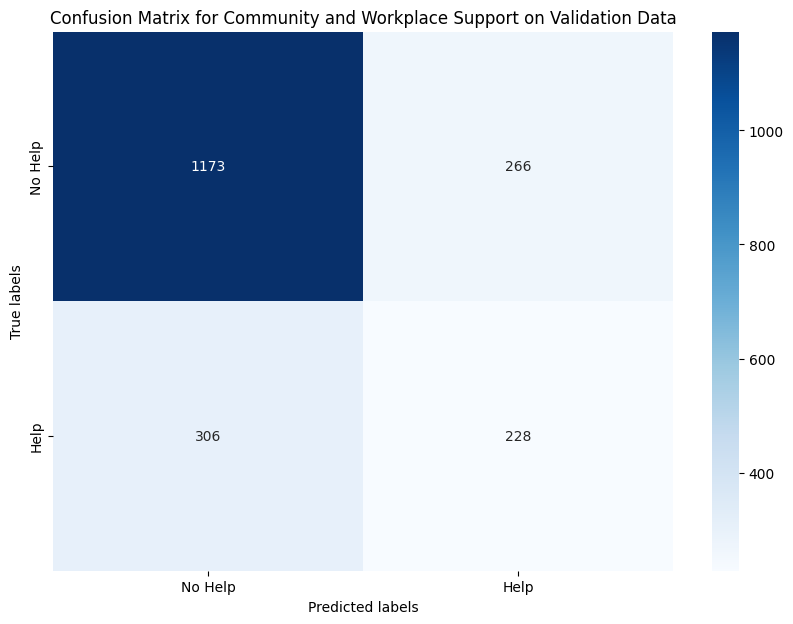

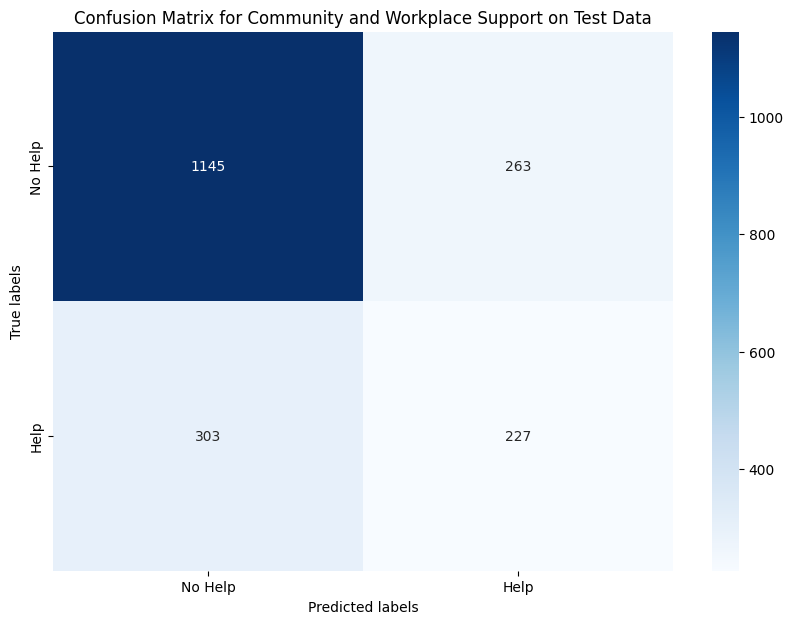

Bias Analysis for Community and Workplace Support:
  gender_Female - Train Error Rate: 0.3153688056633935
  gender_Female - Validation Error Rate: 0.3035019455252918
  gender_Female - Test Error Rate: 0.3050682261208577
  gender_Male - Train Error Rate: 0.30753192598384155
  gender_Male - Validation Error Rate: 0.2749469214437367
  gender_Male - Test Error Rate: 0.27692307692307694
  gender_Other - Train Error Rate: 0.7142857142857143
  gender_Other - Validation Error Rate: 0.3333333333333333
  gender_Other - Test Error Rate: 0.5
Error Rates for Legal and Official Support:
  Training: 0.19421135838501763
  Validation: 0.2017232640648758
  Test: 0.173890608875129


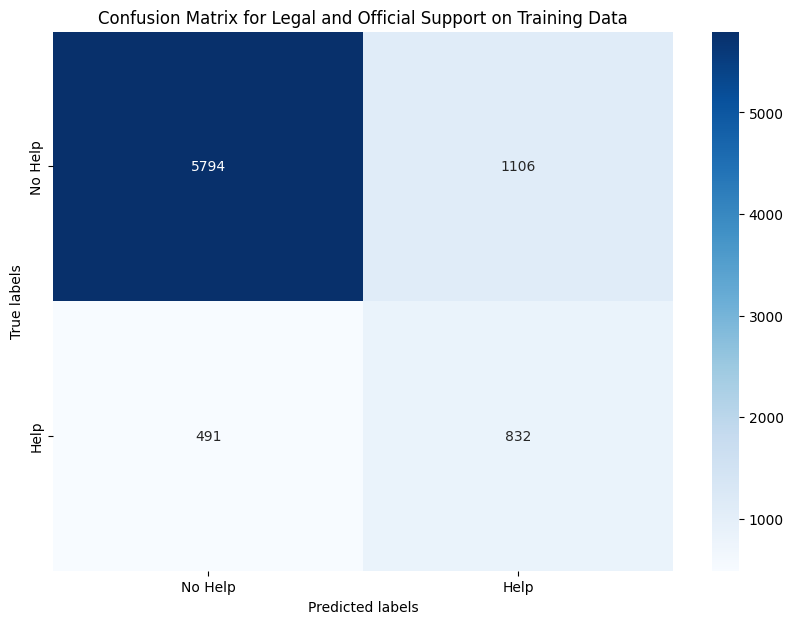

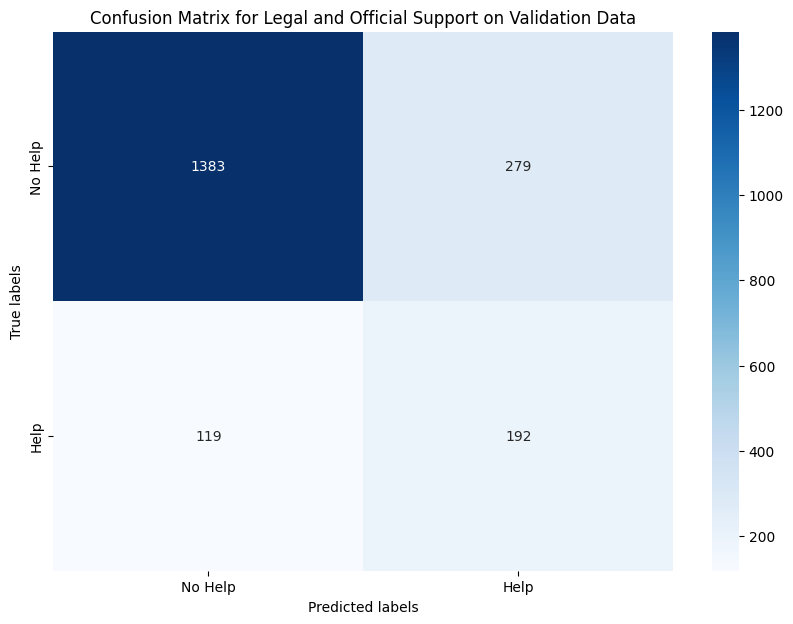

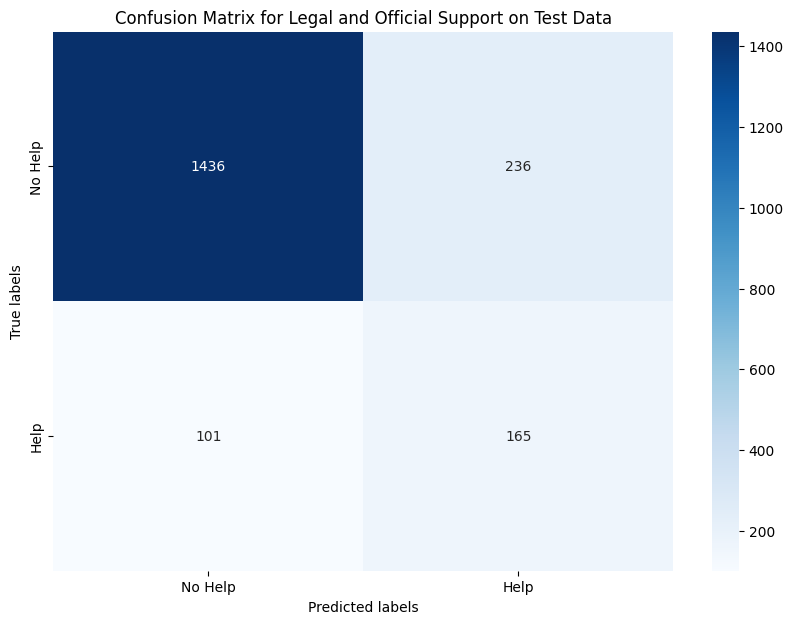

Bias Analysis for Legal and Official Support:
  gender_Female - Train Error Rate: 0.1918246174925782
  gender_Female - Validation Error Rate: 0.19552529182879377
  gender_Female - Test Error Rate: 0.1705653021442495
  gender_Male - Train Error Rate: 0.19728954912692206
  gender_Male - Validation Error Rate: 0.2091295116772824
  gender_Male - Test Error Rate: 0.17692307692307693
  gender_Other - Train Error Rate: 0.0
  gender_Other - Validation Error Rate: 0.0
  gender_Other - Test Error Rate: 0.5
Error Rates for No Help Sought:
  Training: 0.24832786087802505
  Validation: 0.25747592498732896
  Test: 0.21052631578947367


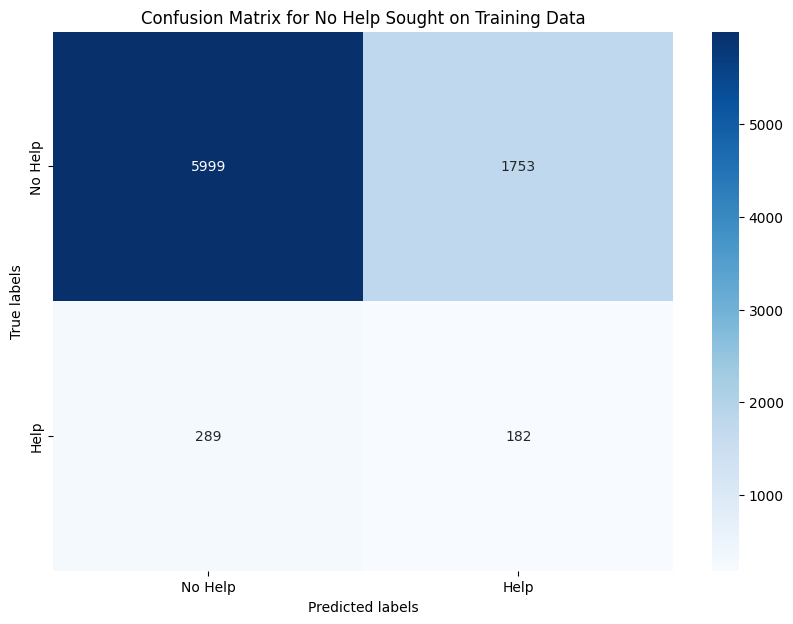

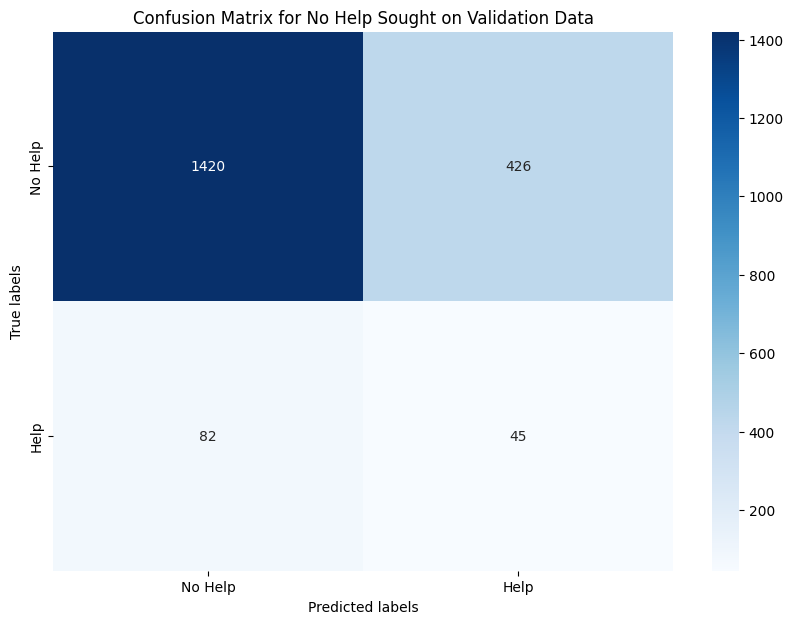

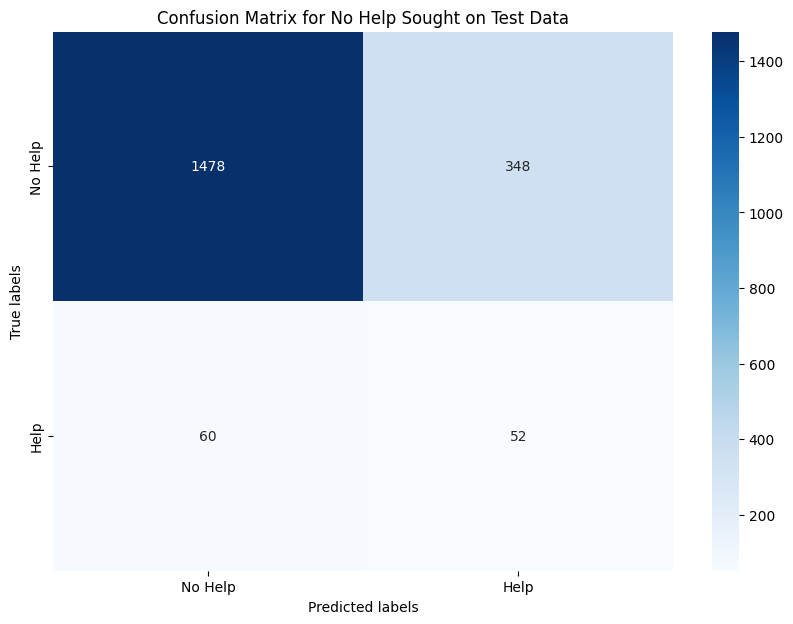

Bias Analysis for No Help Sought:
  gender_Female - Train Error Rate: 0.2347567937885362
  gender_Female - Validation Error Rate: 0.2237354085603113
  gender_Female - Test Error Rate: 0.19395711500974658
  gender_Male - Train Error Rate: 0.2642689601250977
  gender_Male - Validation Error Rate: 0.2929936305732484
  gender_Male - Test Error Rate: 0.22967032967032966
  gender_Other - Train Error Rate: 0.0
  gender_Other - Validation Error Rate: 0.6666666666666666
  gender_Other - Test Error Rate: 0.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Error rates calculation
def calculate_error_rates(y_true, y_pred):
    return np.mean(y_true != y_pred, axis=0)

#Plot confusion matrix function
def plot_confusion_matrix(cm, class_names, target, dataset):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for {target} on {dataset} Data')
    plt.show()

#Analyze and plot error rates and biases for each target
for target, model in zip(targets, classifiers):
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    train_error = calculate_error_rates(y_train[target], y_train_pred)
    val_error = calculate_error_rates(y_val[target], y_val_pred)
    test_error = calculate_error_rates(y_test[target], y_test_pred)

    print(f"Error Rates for {target}:")
    print(f"  Training: {train_error}")
    print(f"  Validation: {val_error}")
    print(f"  Test: {test_error}")
    
    #confusion matrices
    cm_train = confusion_matrix(y_train[target], y_train_pred)
    cm_val = confusion_matrix(y_val[target], y_val_pred)
    cm_test = confusion_matrix(y_test[target], y_test_pred)
    
    plot_confusion_matrix(cm_train, ['No Help', 'Help'], target, 'Training')
    plot_confusion_matrix(cm_val, ['No Help', 'Help'], target, 'Validation')
    plot_confusion_matrix(cm_test, ['No Help', 'Help'], target, 'Test')

    #Bias analysis for demographic factors
    print(f"Bias Analysis for {target}:")
    for category in ['gender_Female', 'gender_Male', 'gender_Other']:
        mask_train = X_train[category] == 1
        mask_val = X_val[category] == 1
        mask_test = X_test[category] == 1
        
        y_train_pred = model.predict(X_train_scaled[mask_train])
        y_val_pred = model.predict(X_val_scaled[mask_val])
        y_test_pred = model.predict(X_test_scaled[mask_test])
        
        error_train = calculate_error_rates(y_train[target][mask_train], y_train_pred)
        error_val = calculate_error_rates(y_val[target][mask_val], y_val_pred)
        error_test = calculate_error_rates(y_test[target][mask_test], y_test_pred)
        
        print(f"  {category} - Train Error Rate: {error_train}")
        print(f"  {category} - Validation Error Rate: {error_val}")
        print(f"  {category} - Test Error Rate: {error_test}")


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

#calculate error rates
def calculate_error_rates(y_true, y_pred):
    return np.mean(np.not_equal(y_true, y_pred))

#data
data = pd.read_csv("cleaned_data_15_4_2024.csv")
feature_columns = ['age', 'Violence and Abuse', 'Accidents and Medical', 'Theft and Fraud', 'Loss and Death', 'gender_Female', 'gender_Male', 'gender_Other']
targets = ['Personal Support', 'Professional and Specialized Support', 'Community and Workplace Support', 'Legal and Official Support', 'No Help Sought']

#Splitting the data
train_data = data[data['year_of_survey'] <= 2021]
X_train, y_train = train_data[feature_columns], train_data[targets]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#Assuming 'model' is already trained and available
model = MultiOutputClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)

#Initialize DataFrame to hold error rates
error_rate_df = pd.DataFrame(columns=['Demographic', 'Group', 'Target', 'Error Rate'])

#Function to analyze errors by demographic groups
def analyze_demographics(X, y_true, y_pred, demographic, target_name, bins=None):
    if bins:
        # Creating bin labels
        labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
        X['Binned'] = pd.cut(X[demographic], bins=bins, labels=labels)
        groups = labels
    else:
        groups = X[demographic].unique()

    for group in groups:
        mask = X[demographic] == group if not bins else X['Binned'] == group
        error_rate = calculate_error_rates(y_true[mask], y_pred[mask])
        error_rate_df.loc[len(error_rate_df)] = [demographic, group, target_name, error_rate]

#Age bins and demographics
age_bins = [0, 18, 35, 55, 75, 100]
demographics = ['gender_Female', 'gender_Male', 'gender_Other']

for demo in demographics:
    for target, predictions in zip(targets, y_train_pred.T):
        analyze_demographics(train_data, y_train[target], predictions, demo, target)

for target, predictions in zip(targets, y_train_pred.T):
    analyze_demographics(train_data, y_train[target], predictions, 'age', target, bins=age_bins)

print(error_rate_df)
error_rate_df.to_csv('error_rates_by_demographic.csv', index=False)

      Demographic   Group                                Target  Error Rate
0   gender_Female    True                      Personal Support    0.103448
1   gender_Female   False                      Personal Support    0.144381
2   gender_Female    True  Professional and Specialized Support    0.185430
3   gender_Female   False  Professional and Specialized Support    0.163892
4   gender_Female    True       Community and Workplace Support    0.300982
5   gender_Female   False       Community and Workplace Support    0.298907
6   gender_Female    True            Legal and Official Support    0.156200
7   gender_Female   False            Legal and Official Support    0.167014
8   gender_Female    True                        No Help Sought    0.047728
9   gender_Female   False                        No Help Sought    0.068158
10    gender_Male   False                      Personal Support    0.103283
11    gender_Male    True                      Personal Support    0.144644
12    gender

C:\Users\Christina Meinti\AppData\Local\Temp\ipykernel_31824\2204809375.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Binned'] = pd.cut(X[demographic], bins=bins, labels=labels)
C:\Users\Christina Meinti\AppData\Local\Temp\ipykernel_31824\2204809375.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Binned'] = pd.cut(X[demographic], bins=bins, labels=labels)
C:\Users\Christina Meinti\AppData\Local\Temp\ipykernel_31824\2204809375.py:36: SettingWithCopyWarning: 
A value is trying to be set on a

In [2]:
error_rate_df = pd.read_csv("error_rates_by_demographic.csv")
yres = error_rate_df[error_rate_df.Group == "True"]
yres

,Demographic,Group,Target,Error Rate
0,gender_Female,True,Personal Support,0.103448
2,gender_Female,True,Professional and Specialized Support,0.185430
4,gender_Female,True,Community and Workplace Support,0.300982
6,gender_Female,True,Legal and Official Support,0.156200
8,gender_Female,True,No Help Sought,0.047728
11,gender_Male,True,Personal Support,0.144644
13,gender_Male,True,Professional and Specialized Support,0.163930
15,gender_Male,True,Community and Workplace Support,0.298931
17,gender_Male,True,Legal and Official Support,0.167318
19,gender_Male,True,No Help Sought,0.068283


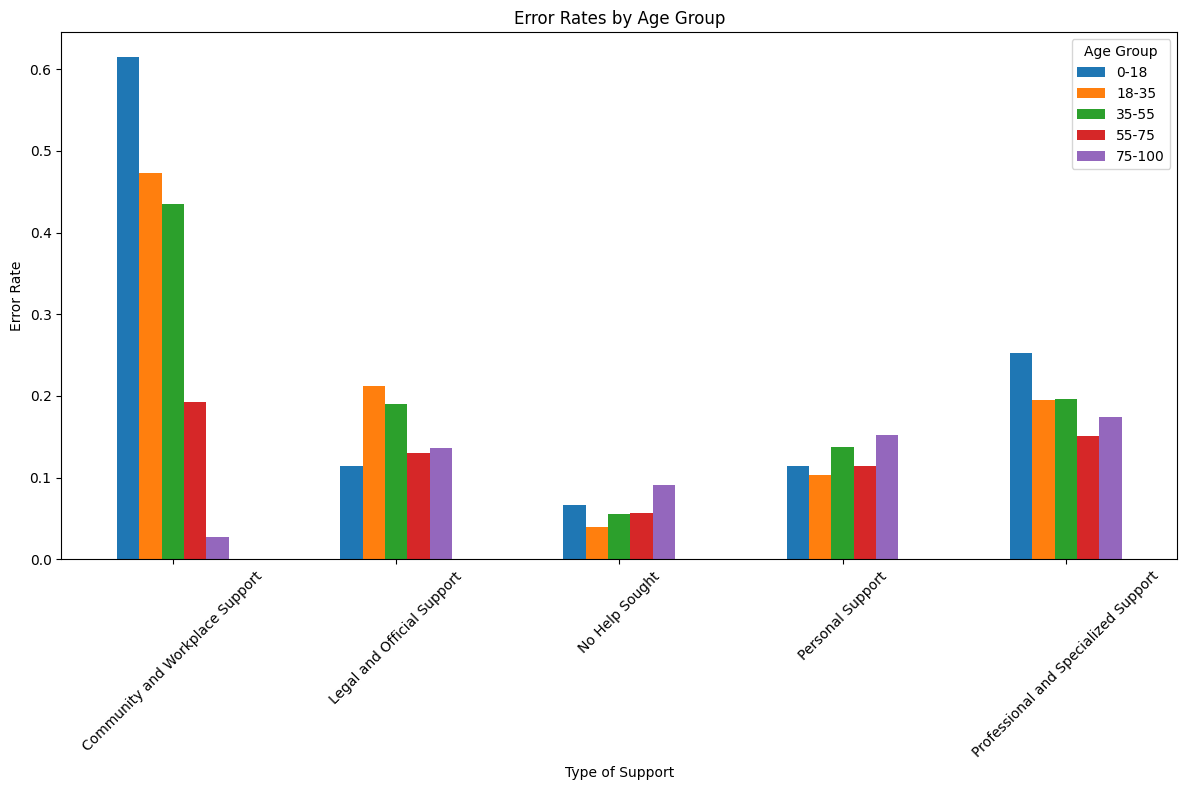

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

#Data
data = {
    "Age Group": ["0-18", "18-35", "35-55", "55-75", "75-100",
                  "0-18", "18-35", "35-55", "55-75", "75-100",
                  "0-18", "18-35", "35-55", "55-75", "75-100",
                  "0-18", "18-35", "35-55", "55-75", "75-100",
                  "0-18", "18-35", "35-55", "55-75", "75-100"],
    "Type of Support": ["Personal Support", "Personal Support", "Personal Support", "Personal Support", "Personal Support",
                        "Professional and Specialized Support", "Professional and Specialized Support", "Professional and Specialized Support", "Professional and Specialized Support", "Professional and Specialized Support",
                        "Community and Workplace Support", "Community and Workplace Support", "Community and Workplace Support", "Community and Workplace Support", "Community and Workplace Support",
                        "Legal and Official Support", "Legal and Official Support", "Legal and Official Support", "Legal and Official Support", "Legal and Official Support",
                        "No Help Sought", "No Help Sought", "No Help Sought", "No Help Sought", "No Help Sought"],
    "Error Rate": [0.114458, 0.103663, 0.138009, 0.114799, 0.151786,
                   0.253012, 0.195577, 0.195928, 0.151314, 0.174745,
                   0.614458, 0.473393, 0.435294, 0.192531, 0.026786,
                   0.114458, 0.212163, 0.190498, 0.130567, 0.136480,
                   0.066265, 0.040083, 0.056109, 0.057261, 0.090561]
}

df = pd.DataFrame(data)

pivot_df = df.pivot(index='Type of Support', columns='Age Group', values='Error Rate')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

pivot_df.plot(kind='bar', figsize=(12, 8), color=colors)
#Plot
plt.title('Error Rates by Age Group')
plt.ylabel('Error Rate')
plt.xlabel('Type of Support')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()

plt.show()

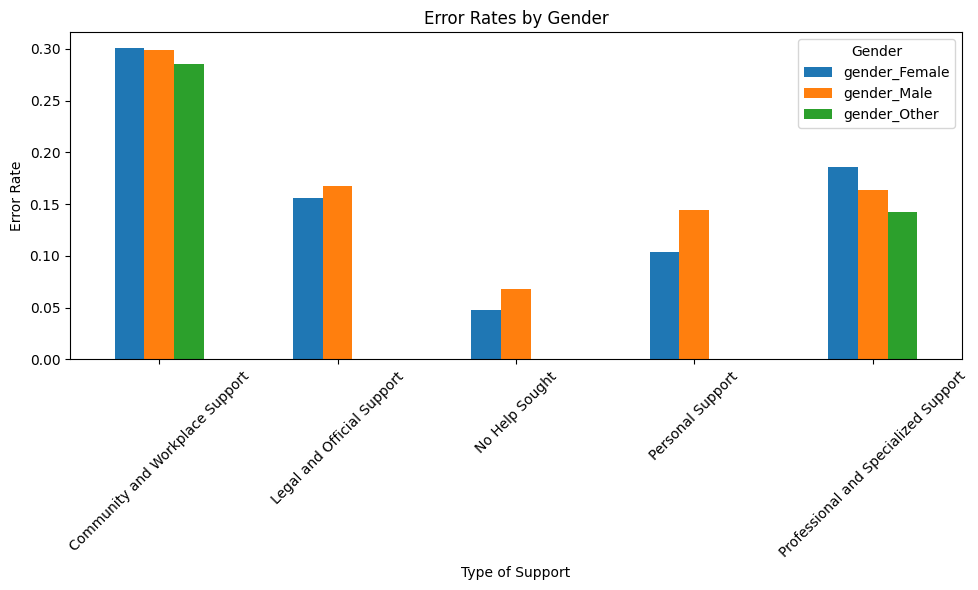

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

#Data
data = {
    "Demographic": ["gender_Female", "gender_Female", "gender_Female", "gender_Female", "gender_Female",
                    "gender_Male", "gender_Male", "gender_Male", "gender_Male", "gender_Male",
                    "gender_Other", "gender_Other", "gender_Other", "gender_Other", "gender_Other"],
    "Group": ["Personal Support", "Professional and Specialized Support", "Community and Workplace Support",
              "Legal and Official Support", "No Help Sought", "Personal Support", "Professional and Specialized Support",
              "Community and Workplace Support", "Legal and Official Support", "No Help Sought",
              "Personal Support", "Professional and Specialized Support", "Community and Workplace Support",
              "Legal and Official Support", "No Help Sought"],
    "Error Rate": [0.103448, 0.185430, 0.300982, 0.156200, 0.047728,
                   0.144644, 0.163930, 0.298931, 0.167318, 0.068283,
                   0.000000, 0.142857, 0.285714, 0.000000, 0.000000]
}

df = pd.DataFrame(data)


df = df[~((df['Demographic'] == 'gender_Other') & (df['Error Rate'] == 0))]

pivot_df = df.pivot(index='Group', columns='Demographic', values='Error Rate')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot
pivot_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Error Rates by Gender')
plt.ylabel('Error Rate')
plt.xlabel('Type of Support')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()

plt.show()

ExactExplainer explainer: 8224it [35:37,  3.83it/s]                          


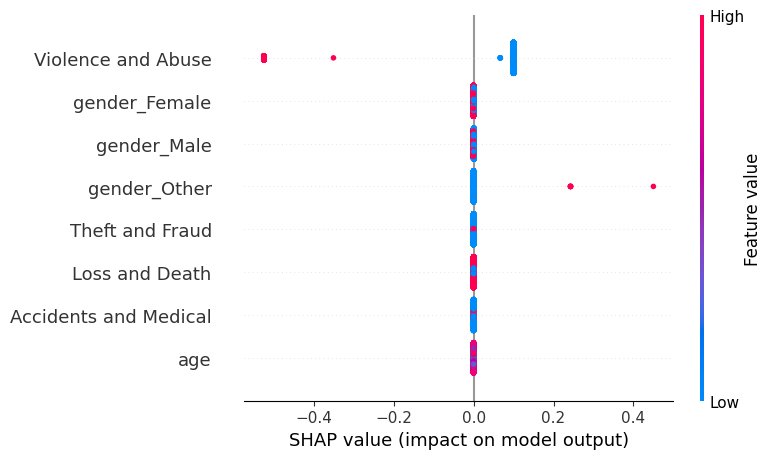

ExactExplainer explainer: 8224it [10:52, 12.41it/s]                          


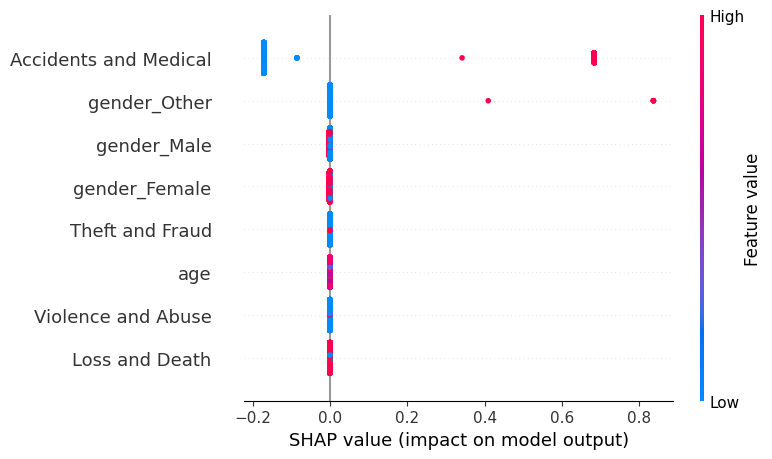

ExactExplainer explainer: 8224it [13:18, 10.17it/s]                          


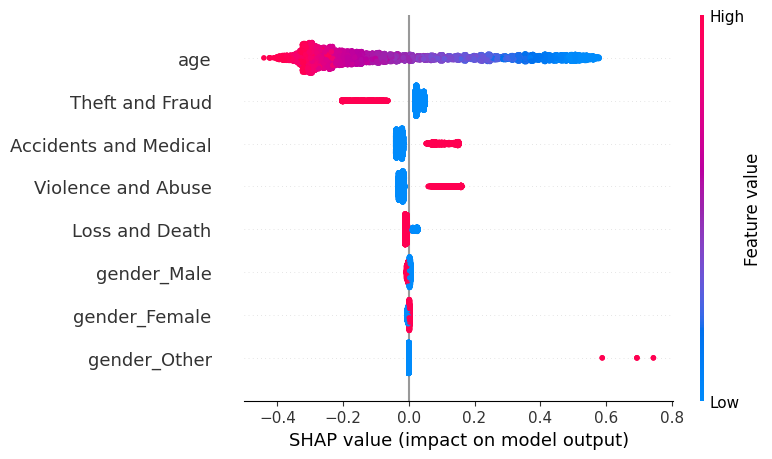

ExactExplainer explainer: 8224it [20:25,  6.65it/s]                          


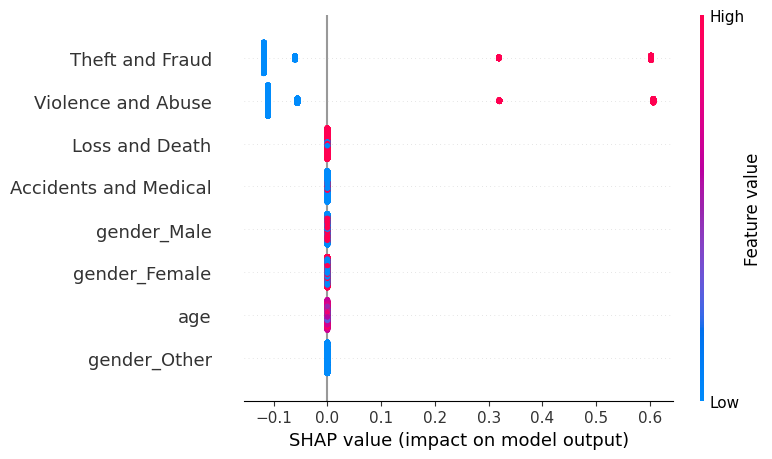

ExactExplainer explainer: 8224it [1:05:57,  2.07it/s]                          


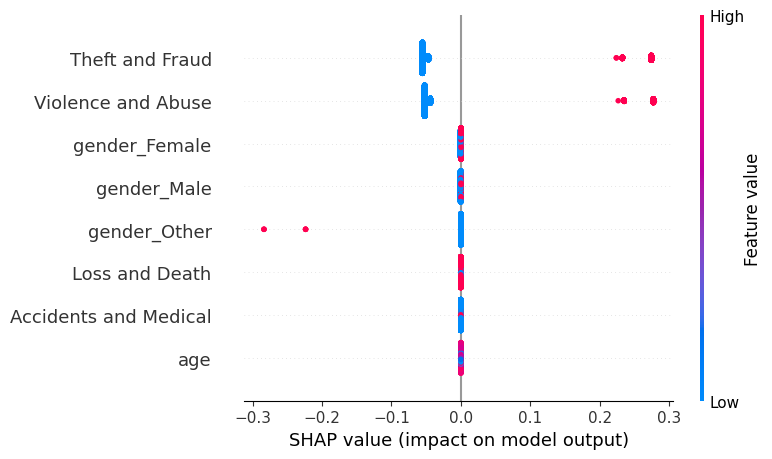

<Figure size 640x480 with 0 Axes>

In [15]:
import shap
import matplotlib.pyplot as plt

#Loop over each classifier and each label
for i, model in enumerate(classifiers):
    predict_function = model.predict_proba
    explainer = shap.Explainer(predict_function, masker)
    shap_values = explainer(X_train_scaled)
    shap_values_for_class = shap_values[..., 1]
    shap.summary_plot(shap_values_for_class.values, X_train_scaled, feature_names=feature_columns)
    
    #Save plot
    plt.savefig(f'shap_summary_plot_label_{i}.png')
    plt.clf()


ExactExplainer explainer: 1974it [07:53,  4.07it/s]                          


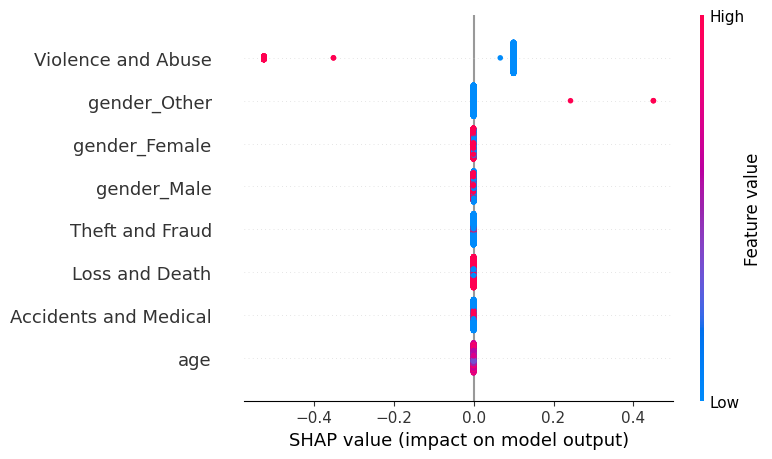

ExactExplainer explainer: 1974it [02:21, 12.96it/s]                          


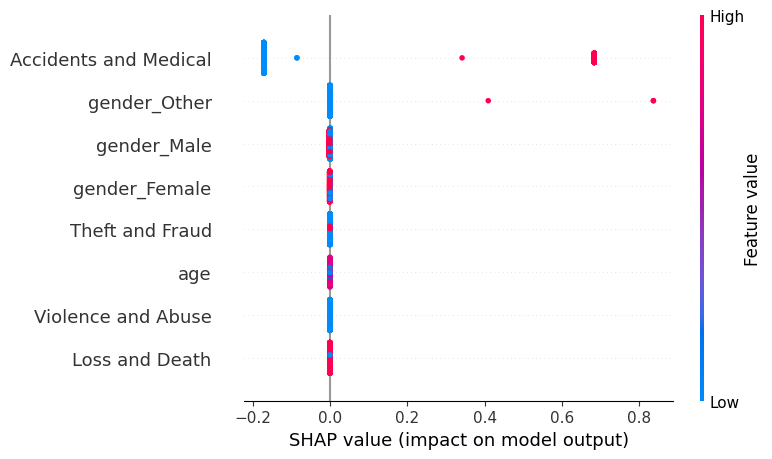

ExactExplainer explainer: 1974it [03:05, 10.03it/s]                          


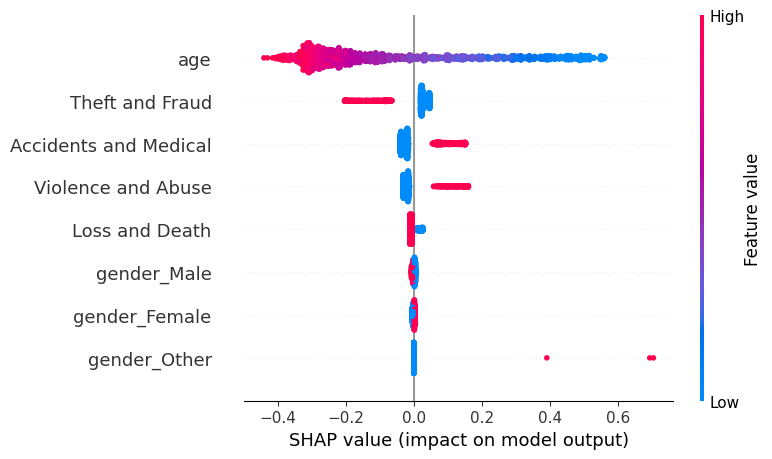

ExactExplainer explainer: 1974it [04:43,  6.72it/s]                          


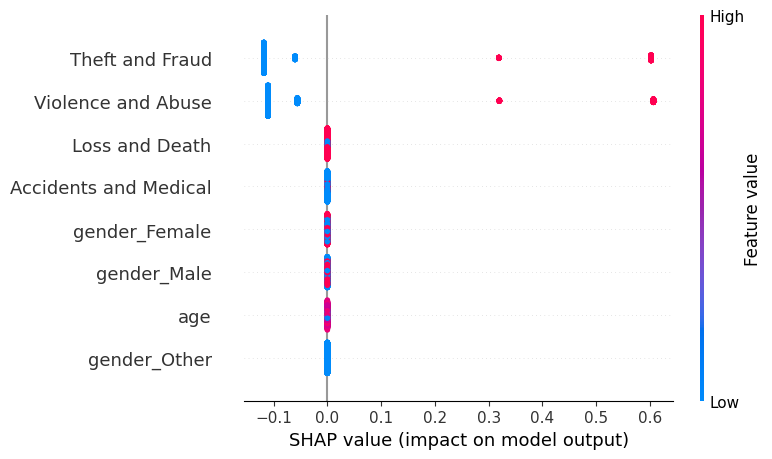

ExactExplainer explainer: 1974it [14:41,  2.21it/s]                          


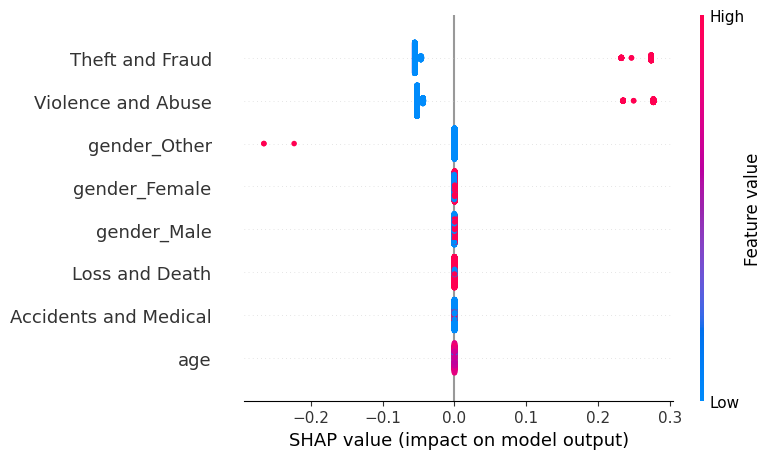

<Figure size 640x480 with 0 Axes>

In [14]:
import shap
import matplotlib.pyplot as plt

#Loop over each classifier and each label
for i, model in enumerate(classifiers):
    predict_function = model.predict_proba
    explainer = shap.Explainer(predict_function, masker)
    shap_values = explainer(X_val_scaled)
    shap_values_for_class = shap_values[..., 1]
    shap.summary_plot(shap_values_for_class.values, X_val_scaled, feature_names=feature_columns)
    
    #Save plot
    plt.savefig(f'shap_summary_plot_validation_label_{i}.png')
    plt.clf()


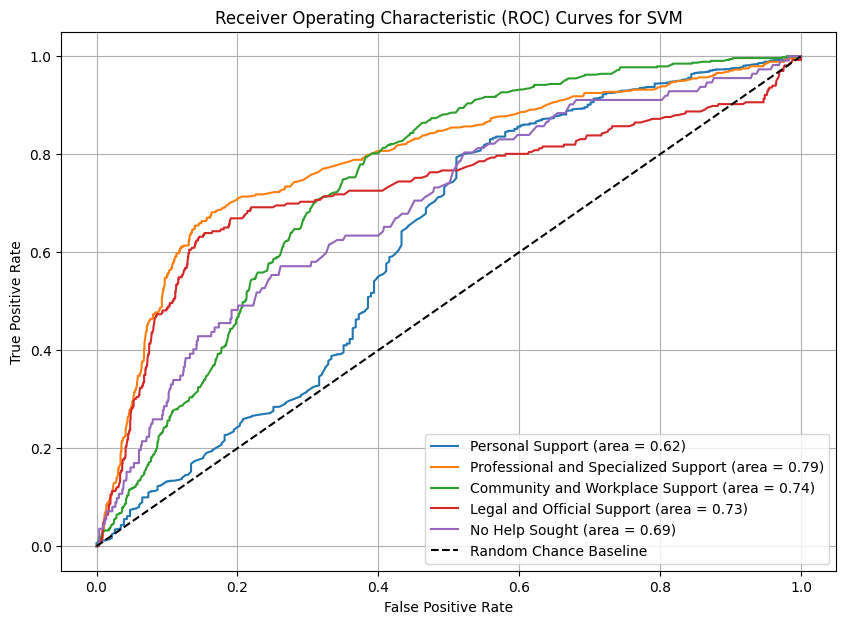

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

#plot ROC-AUC curves for each target
def plot_multiclass_roc_auc(y_true, y_scores, targets, figsize=(10, 7)):
    # Create a figure
    plt.figure(figsize=figsize)


    for i, target in enumerate(targets):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{target} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for SVM')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


y_scores = np.column_stack([model.predict_proba(X_test_scaled)[:, 1] for model in classifiers])
y_true = y_test.to_numpy()

#Plot ROC-AUC curves
plot_multiclass_roc_auc(y_true, y_scores, targets)
